In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import seaborn as sns

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 # Use 14 point font
sns.set(style="whitegrid")

In [ ]:
!p

In [182]:
path_athena = '/eos/user/j/jlai/g200/gpu/G-200/traccc-athena/run/event000000000-measurements.csv'
path_traccc = '/eos/user/j/jlai/Traccc/traccc/data/output/measurements.csv'
path = '/eos/user/j/jlai/Traccc/traccc/data/output/event000000000-measurements.csv'
path_act = '/eos/project/a/atlas-eftracking/GPU/ITk_data/actsToAthenaIdentifierMap.txt'
path_detray = '/eos/project/a/atlas-eftracking/GPU/ITk_data/athenaIdentifierToDetrayMap.txt'
path_map =  "/eos/user/j/jlai/g200/gpu/G-200/traccc-athena/run/ITk_athena_map.csv"

dfa = pd.read_csv(path_athena)
dfc = pd.read_csv(path_traccc)
df = pd.read_csv(path)
df_act = pd.read_csv(path_act)
df_detray = pd.read_csv(path_detray, header=None)
df_detray.columns = ['athena_id', 'detray_id'] # assign header to detray2athena map
df_map = pd.read_csv(path_map)

In [184]:
display(dfc.head()), display(dfa.head()), display(df_detray.head()), display(df_map.head())

,local0,local1,var_local0,var_local1,geometry_id,measurement_id,cluster_link,meas_dim
0,-32.170132,0.0,0.000485,30.023199,1536010436653820607,68813,18446744073709551615,1
1,-29.575151,0.0,0.000485,30.023199,1536010436653820607,68814,18446744073709551615,1
2,-27.285463,0.0,0.012136,30.023199,1536010436653820607,68815,18446744073709551615,1
3,-23.774607,0.0,0.000485,30.023199,1536010436653820607,68816,18446744073709551615,1
4,-21.484917,0.0,0.000485,30.023199,1536010436653820607,68817,18446744073709551615,1


,measurement_id,geometry_id,local_key,local0,local1,phi,theta,time,var_local0,var_local1,var_phi,var_theta,var_time
0,0,1536010436653820607,6,-32.9015,392.615,0,0,0,0.0025,0.0025,0,0,0
1,1,1536010436653820607,6,-30.3273,392.822,0,0,0,0.0025,0.0025,0,0,0
2,2,1536010436653820607,6,-28.0545,392.991,0,0,0,0.0025,0.0025,0,0,0
3,3,1536010436653820607,6,-24.5671,393.224,0,0,0,0.0025,0.0025,0,0,0
4,4,1536010436653820607,6,-22.2913,393.360,0,0,0,0.0025,0.0025,0,0,0


,athena_id,detray_id
0,0x40440000000000,13792292246659967
1,0x49440000000000,13792292380877759
2,0x41440000000000,13792292515095551
3,0x42440000000000,13792292649313343
4,0x48440000000000,13792292783531135


,Module_ID,Barrel_ec,Layer_Disk,Phi,Eta,Side,Strip,Wafer_Hash
0,0x800380000000000,-2,0,0,0,0,0,0
1,0x800380000000000,-2,0,0,0,1,0,0
2,0x800390000000000,-2,0,0,1,0,0,2
3,0x800390000000000,-2,0,0,1,1,0,2
4,0x8003a0000000000,-2,0,0,2,0,0,4


(None, None, None, None)

In [186]:
# Create the mapping clearly from df_detray to df_map (strip only)
detray_to_athena_barrel = df_detray.merge(
    df_map[['Module_ID', 'Barrel_ec']], 
    left_on='athena_id', 
    right_on='Module_ID',
    how='left'
)[['detray_id', 'athena_id', 'Barrel_ec']]

detray_to_athena_barrel.dropna(subset=['athena_id', 'Barrel_ec'], inplace=True)

detray_to_athena_barrel = detray_to_athena_barrel.drop_duplicates() # Drop duplicated rows
detray_to_athena_barrel

,detray_id,athena_id,Barrel_ec
9164,1536010436251167231,0x945380000000000,-2.0
9166,1536010436385385023,0x945b80000000000,-2.0
9168,1536010436519602815,0x946380000000000,-2.0
9170,1536010436653820607,0x946380000000000,-2.0
9172,1536010436788038399,0x946b80000000000,-2.0
...,...,...,...
108226,1684635902900161215,0xd5ec90000000000,2.0
108228,1684635903034379007,0xd5f490000000000,2.0
108230,1684635903168596799,0xd5f490000000000,2.0
108232,1684635903302814591,0xd5fc90000000000,2.0


In [187]:
dfc = dfc.merge(
    detray_to_athena_barrel,
    left_on='geometry_id',
    right_on='detray_id',
    how='left'
)

# dfa
dfa = dfa.merge(
    detray_to_athena_barrel,
    left_on='geometry_id',
    right_on='detray_id',
    how='left'
)

# Drop redundant 'detray_id' if no longer needed:
dfc.drop(columns=['detray_id'], inplace=True)
dfa = dfa.drop(columns=['detray_id'])

# Checking results
display(dfc), display(dfa)

,local0,local1,var_local0,var_local1,geometry_id,measurement_id,cluster_link,meas_dim,athena_id,Barrel_ec
0,-32.170132,0.0,0.000485,30.023199,1536010436653820607,68813,18446744073709551615,1,0x946380000000000,-2.0
1,-29.575151,0.0,0.000485,30.023199,1536010436653820607,68814,18446744073709551615,1,0x946380000000000,-2.0
2,-27.285463,0.0,0.012136,30.023199,1536010436653820607,68815,18446744073709551615,1,0x946380000000000,-2.0
3,-23.774607,0.0,0.000485,30.023199,1536010436653820607,68816,18446744073709551615,1,0x946380000000000,-2.0
4,-21.484917,0.0,0.000485,30.023199,1536010436653820607,68817,18446744073709551615,1,0x946380000000000,-2.0
...,...,...,...,...,...,...,...,...,...,...
106817,-31.583271,0.0,0.000540,301.622162,1684635903437032383,91971,18446744073709551615,1,0xd5fc90000000000,2.0
106818,-20.720236,0.0,0.000540,301.622162,1684635903437032383,91972,18446744073709551615,1,0xd5fc90000000000,2.0
106819,11.144670,0.0,0.000540,301.622162,1684635903437032383,91973,18446744073709551615,1,0xd5fc90000000000,2.0
106820,16.053154,0.0,0.000540,301.622162,1684635903437032383,91974,18446744073709551615,1,0xd5fc90000000000,2.0


,measurement_id,geometry_id,local_key,local0,local1,phi,theta,time,var_local0,var_local1,var_phi,var_theta,var_time,athena_id,Barrel_ec
0,0,1536010436653820607,6,-32.9015,392.615,0,0,0,0.0025,0.0025,0,0,0,0x946380000000000,-2.0
1,1,1536010436653820607,6,-30.3273,392.822,0,0,0,0.0025,0.0025,0,0,0,0x946380000000000,-2.0
2,2,1536010436653820607,6,-28.0545,392.991,0,0,0,0.0025,0.0025,0,0,0,0x946380000000000,-2.0
3,3,1536010436653820607,6,-24.5671,393.224,0,0,0,0.0025,0.0025,0,0,0,0x946380000000000,-2.0
4,4,1536010436653820607,6,-22.2913,393.360,0,0,0,0.0025,0.0025,0,0,0,0x946380000000000,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100930,100930,1684635903437032383,6,-31.8960,937.161,0,0,0,0.0025,0.0025,0,0,0,0xd5fc90000000000,2.0
100931,100931,1684635903437032383,6,-21.0784,937.467,0,0,0,0.0025,0.0025,0,0,0,0xd5fc90000000000,2.0
100932,100932,1684635903437032383,6,10.7680,937.642,0,0,0,0.0025,0.0025,0,0,0,0xd5fc90000000000,2.0
100933,100933,1684635903437032383,6,15.6716,937.573,0,0,0,0.0025,0.0025,0,0,0,0xd5fc90000000000,2.0


(None, None)

In [188]:
# Check Layer_Disk values for Barrel_ec == 0
barrel_0_layers = df_map[df_map['Barrel_ec'] == 0]['Layer_Disk'].unique()
print("Barrel_ec = 0 (barrel) unique Layer_Disk values:", np.sort(barrel_0_layers))

# Check for Barrel_ec != 0 (endcap or others)
other_layers = df_map[df_map['Barrel_ec'] != 0]['Layer_Disk'].unique()

print("Barrel (Barrel_ec=0) Layers:", df_map[df_map['Barrel_ec'] == 0]['Layer_Disk'].unique())
print("Endcap (Barrel_ec!=0) Layers:", other_layers)


Barrel_ec = 0 (barrel) unique Layer_Disk values: [0 1 2 3]
Barrel (Barrel_ec=0) Layers: [0 1 2 3]
Endcap (Barrel_ec!=0) Layers: [0 1 2 3 4 5]


## Difference in Number of Measurements for same geometry_id

In [54]:
Counter(sorted(dfc.geometry_id))

Counter({1536010436653820607: 11,
         1536010436922256191: 8,
         1536010437190691775: 11,
         1536010437459127359: 22,
         1536010437727562943: 7,
         1536010437995998527: 12,
         1536010438264434111: 18,
         1536010438532869695: 16,
         1536010438801305279: 10,
         1536010439069740863: 16,
         1536010439606612031: 10,
         1536010439875047615: 12,
         1536010440009265407: 11,
         1536010440143483199: 12,
         1536010440277700991: 10,
         1536010440546136575: 5,
         1536010440948789951: 15,
         1536010441083007743: 11,
         1536010441351443327: 16,
         1536010441619878911: 12,
         1536010441888314495: 10,
         1536010442156750079: 15,
         1536010442425185663: 11,
         1536010442827839039: 10,
         1536010442962056831: 8,
         1536010443230492415: 8,
         1536010443498927999: 15,
         1536010443901581375: 6,
         1536010444170016959: 11,
         15360104443

In [55]:
Counter(sorted(dfa.geometry_id))

Counter({1536010436653820607: 11,
         1536010436922256191: 8,
         1536010437190691775: 11,
         1536010437459127359: 22,
         1536010437727562943: 6,
         1536010437995998527: 11,
         1536010438264434111: 17,
         1536010438532869695: 15,
         1536010438801305279: 10,
         1536010439069740863: 15,
         1536010439606612031: 10,
         1536010439875047615: 10,
         1536010440009265407: 11,
         1536010440143483199: 12,
         1536010440277700991: 10,
         1536010440546136575: 5,
         1536010440948789951: 14,
         1536010441083007743: 11,
         1536010441351443327: 16,
         1536010441619878911: 12,
         1536010441888314495: 10,
         1536010442156750079: 14,
         1536010442425185663: 11,
         1536010442827839039: 10,
         1536010442962056831: 8,
         1536010443230492415: 7,
         1536010443498927999: 15,
         1536010443901581375: 6,
         1536010444170016959: 11,
         15360104443

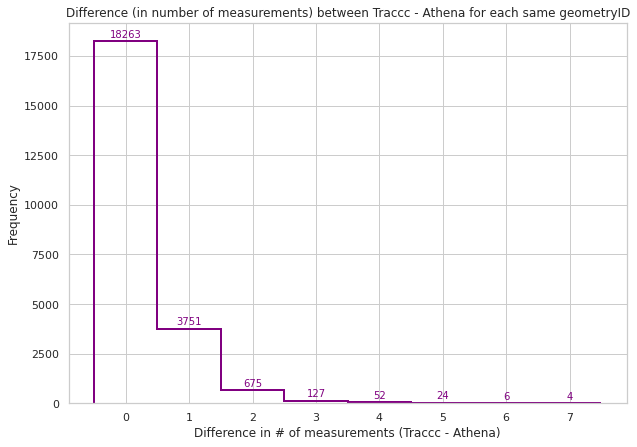

In [189]:
bins = np.arange(-0.5, 8.5 , 1)
diff = np.array(list(Counter(sorted(dfc.geometry_id)).values())) - np.array(list(Counter(sorted(dfa.geometry_id)).values()))

plt.figure(figsize=(10,7))
counts, bins, _ = plt.hist(diff, bins=bins, histtype='step', linewidth=2, color='purple')
plt.ylabel('Frequency')
plt.xlabel('Difference in # of measurements (Traccc - Athena)')
plt.title('Difference (in number of measurements) between Traccc - Athena for each same geometryID')
bin_midpoints = (bins[:-1] + bins[1:]) / 2
plt.xticks(bin_midpoints, labels=[str(int(mid)) for mid in bin_midpoints])
for midpoint, count in zip(bin_midpoints, counts):
    plt.text(midpoint, count + 0.005 * max(counts), int(count),
             ha='center', va='bottom', fontsize=10, color='purple')
plt.grid(True)
plt.show()

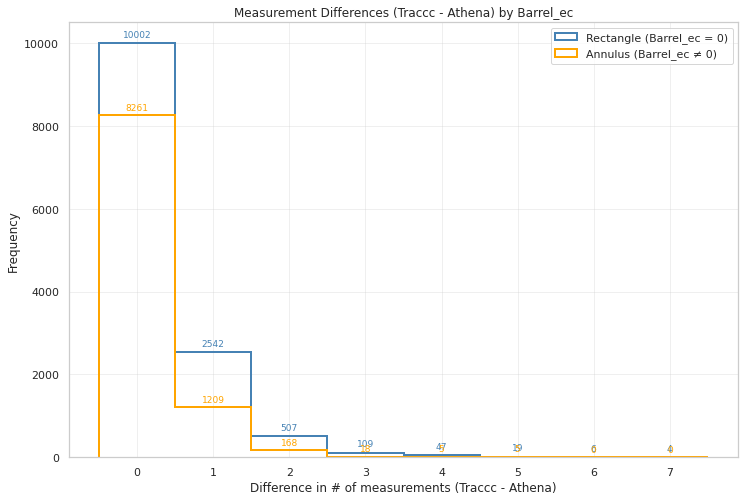

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Calculate differences separately
barrel_ec_0_ids = dfc[dfc['Barrel_ec'] == 0]['geometry_id']
barrel_ec_non0_ids = dfc[dfc['Barrel_ec'] != 0]['geometry_id']

diff_barrel_0 = np.array(list(Counter(barrel_ec_0_ids).values())) - np.array(list(Counter(dfa[dfa['Barrel_ec'] == 0]['geometry_id']).values()))
diff_barrel_non0 = np.array(list(Counter(barrel_ec_non0_ids).values())) - np.array(list(Counter(dfa[dfa['Barrel_ec'] != 0]['geometry_id']).values()))

bins = np.arange(-0.5, 8.5 , 1)
bin_midpoints = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12,8))

# barrel_ec == 0
counts0, _, _ = plt.hist(diff_barrel_0, bins=bins, histtype='step', linewidth=2, color='steelblue', label='Rectangle (Barrel_ec = 0)')
for midpoint, count in zip(bin_midpoints, counts0):
    plt.text(midpoint, count + 0.01 * max(counts0), int(count), ha='center', va='bottom', fontsize=9, color='steelblue')

# barrel_ec != 0
counts_non0, _, _ = plt.hist(diff_barrel_non0, bins=bins, histtype='step', linewidth=2, color='orange', label='Annulus (Barrel_ec ≠ 0)')
for midpoint, count in zip(bin_midpoints, counts_non0):
    plt.text(midpoint, count + 0.01 * max(counts_non0), int(count), ha='center', va='bottom', fontsize=9, color='orange')

plt.ylabel('Frequency')
plt.xlabel('Difference in # of measurements (Traccc - Athena)')
plt.title('Measurement Differences (Traccc - Athena) by Barrel_ec')
plt.xticks(bin_midpoints, labels=[str(int(mid)) for mid in bin_midpoints])
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [90]:
for i in np.arange(0, 14, 1):
    print('Counter:', i, 'Value:', np.sum(diff==i))

Counter: 0 Value: 18263
Counter: 1 Value: 3751
Counter: 2 Value: 675
Counter: 3 Value: 127
Counter: 4 Value: 52
Counter: 5 Value: 24
Counter: 6 Value: 6
Counter: 7 Value: 4
Counter: 8 Value: 0
Counter: 9 Value: 0
Counter: 10 Value: 0
Counter: 11 Value: 0
Counter: 12 Value: 0
Counter: 13 Value: 1


## Difference in measurement values for same geometry_id

In [97]:
gid = np.array(list(Counter(sorted(dfc.geometry_id)).keys()))
index = diff==0
gid2 = gid[index]
gid2, len(gid2)

(array([1536010436653820607, 1536010436922256191, 1536010437190691775, ...,
        1684635902900161215, 1684635903168596799, 1684635903437032383]),
 18263)

In [99]:
diff2 = []
for i in tqdm(gid2):
    diff2.append(np.array(dfc[dfc['geometry_id']==i].local0) - np.array(dfa[dfa['geometry_id']==i].local0))

100%|██████████| 18263/18263 [00:17<00:00, 1050.21it/s]


In [107]:
diff2_flat = np.concatenate(diff2)

In [108]:
diff2_flat

array([0.73136832, 0.75214856, 0.76903667, ..., 0.37667049, 0.38155399,
       0.38175376])

In [112]:
min(diff2_flat), max(diff2_flat)

(-111.58280221557618, 118.18468225708008)

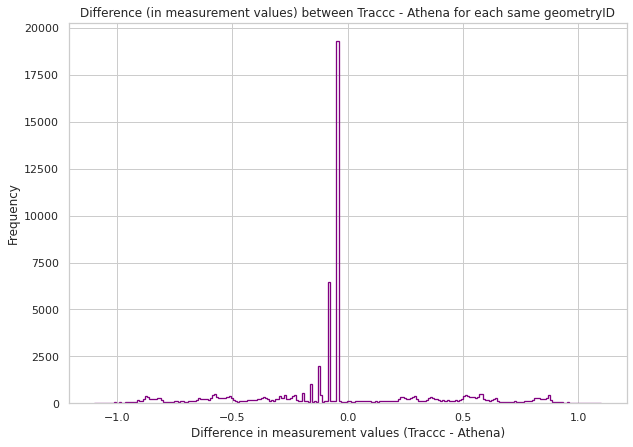

In [136]:
plt.figure(figsize=(10,7))
counts, bins, _ = plt.hist(diff2_flat, bins=np.linspace(-1.1, 1.1, 250), histtype='step', linewidth=1.3, color='purple')
plt.ylabel('Frequency')
plt.xlabel('Difference in measurement values (Traccc - Athena)')
plt.title('Difference (in measurement values) between Traccc - Athena for each same geometryID')
plt.grid(True)
plt.show()

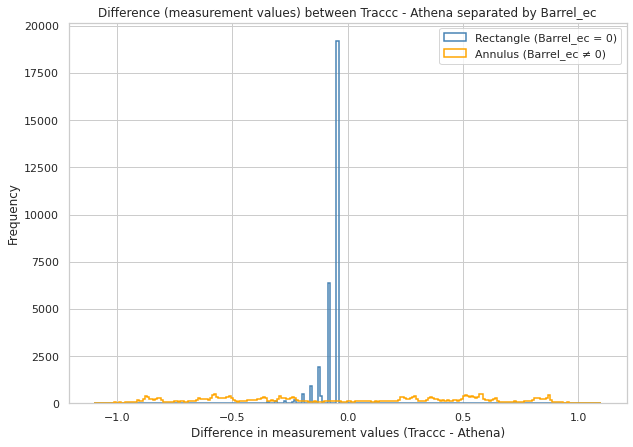

In [206]:
# Ensure these arrays exist clearly
barrel_ec_0_ids = detray_to_athena_barrel[detray_to_athena_barrel['Barrel_ec'] == 0]['detray_id'].unique()
barrel_ec_non0_ids = detray_to_athena_barrel[detray_to_athena_barrel['Barrel_ec'] != 0]['detray_id'].unique()

# Generate diff2 arrays separately:
diff2_barrel_0 = np.concatenate([d for g, d in zip(gid2, diff2) if g in barrel_ec_0_ids])
diff2_barrel_non0 = np.concatenate([d for g, d in zip(gid2, diff2) if g in barrel_ec_non0_ids])

bins = np.linspace(-1.1, 1.1, 250)
plt.figure(figsize=(10,7))

plt.hist(diff2_barrel_0, bins=bins, histtype='step', linewidth=1.5, color='steelblue', label='Rectangle (Barrel_ec = 0)')
plt.hist(diff2_barrel_non0, bins=bins, histtype='step', linewidth=1.5, color='orange', label='Annulus (Barrel_ec ≠ 0)')

plt.ylabel('Frequency')
plt.xlabel('Difference in measurement values (Traccc - Athena)')
plt.title('Difference (measurement values) between Traccc - Athena separated by Barrel_ec')
plt.legend()
plt.grid(True)
plt.show()


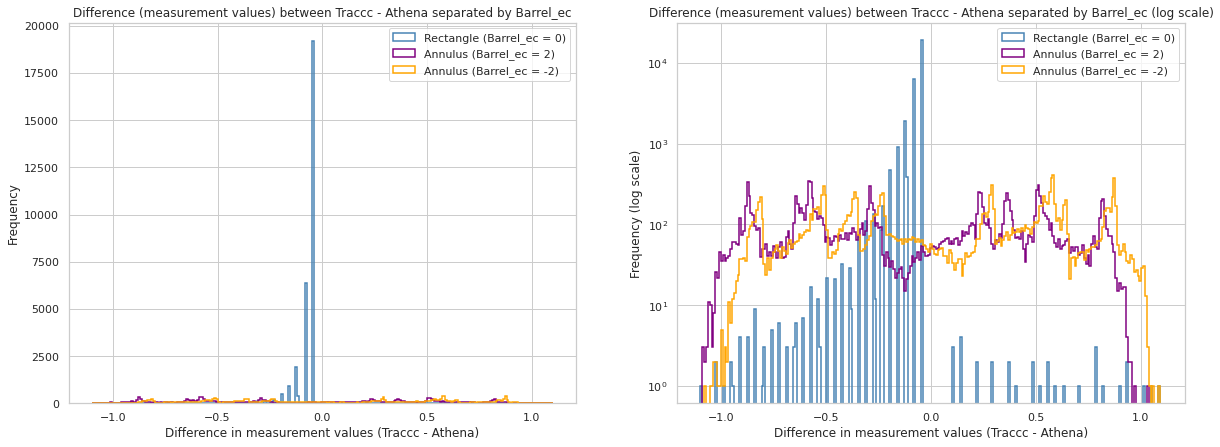

In [205]:
# Ensure these arrays exist clearly
barrel_ec_0_ids = detray_to_athena_barrel[detray_to_athena_barrel['Barrel_ec'] == 0]['detray_id'].unique()
barrel_ec_2_ids = detray_to_athena_barrel[detray_to_athena_barrel['Barrel_ec'] == 2]['detray_id'].unique()
barrel_ec_02_ids = detray_to_athena_barrel[detray_to_athena_barrel['Barrel_ec'] == -2]['detray_id'].unique()

# Generate diff2 arrays separately:
diff2_barrel_0 = np.concatenate([d for g, d in zip(gid2, diff2) if g in barrel_ec_0_ids])
diff2_barrel_2 = np.concatenate([d for g, d in zip(gid2, diff2) if g in barrel_ec_2_ids])
diff2_barrel_02 = np.concatenate([d for g, d in zip(gid2, diff2) if g in barrel_ec_02_ids])

bins = np.linspace(-1.1, 1.1, 250)

plt.figure(figsize=(20,7))

plt.subplot(121)
plt.hist(diff2_barrel_0, bins=bins, histtype='step', linewidth=1.5, color='steelblue', label='Rectangle (Barrel_ec = 0)')
plt.hist(diff2_barrel_2, bins=bins, histtype='step', linewidth=1.5, color='purple', label='Annulus (Barrel_ec = 2)')
plt.hist(diff2_barrel_02, bins=bins, histtype='step', linewidth=1.5, color='orange', label='Annulus (Barrel_ec = -2)')

plt.ylabel('Frequency')
plt.xlabel('Difference in measurement values (Traccc - Athena)')
plt.title('Difference (measurement values) between Traccc - Athena separated by Barrel_ec')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.hist(diff2_barrel_0, bins=bins, histtype='step', linewidth=1.5, color='steelblue', label='Rectangle (Barrel_ec = 0)')
plt.hist(diff2_barrel_2, bins=bins, histtype='step', linewidth=1.5, color='purple', label='Annulus (Barrel_ec = 2)')
plt.hist(diff2_barrel_02, bins=bins, histtype='step', linewidth=1.5, color='orange', label='Annulus (Barrel_ec = -2)')

plt.ylabel('Frequency (log scale)')
plt.xlabel('Difference in measurement values (Traccc - Athena)')
plt.title('Difference (measurement values) between Traccc - Athena separated by Barrel_ec (log scale)')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.show()


In [198]:
np.sum(detray_to_athena_barrel['Barrel_ec'] == 0), np.sum(detray_to_athena_barrel['Barrel_ec'] != 0)

(29568, 19968)

## Looking at one geometry_id measurement

In [24]:
dfc[dfc['geometry_id']==1536010436653820607]

,local0,local1,var_local0,var_local1,geometry_id,measurement_id,cluster_link,meas_dim
1,-32.170132,0.0,0.000485,30.023199,1536010436653820607,80227,18446744073709551615,1
2,-29.575151,0.0,0.000485,30.023199,1536010436653820607,80228,18446744073709551615,1
3,-27.285463,0.0,0.012136,30.023199,1536010436653820607,80229,18446744073709551615,1
4,-23.774607,0.0,0.000485,30.023199,1536010436653820607,80230,18446744073709551615,1
5,-21.484917,0.0,0.000485,30.023199,1536010436653820607,80231,18446744073709551615,1
6,-20.721687,0.0,0.000485,30.023199,1536010436653820607,80232,18446744073709551615,1
7,-12.555129,0.0,0.000485,30.023199,1536010436653820607,80233,18446744073709551615,1
8,-7.594136,0.0,0.000485,30.023199,1536010436653820607,80234,18446744073709551615,1
9,-5.151801,0.0,0.000485,30.023199,1536010436653820607,80235,18446744073709551615,1
10,21.026979,0.0,0.000485,30.023199,1536010436653820607,80236,18446744073709551615,1


In [25]:
dfa[dfa['geometry_id']==1536010436653820607]

,measurement_id,geometry_id,local_key,local0,local1,phi,theta,time,var_local0,var_local1,var_phi,var_theta,var_time
0,0,1536010436653820607,6,-32.90150,392.615,0,0,0,0.0025,0.0025,0,0,0
1,1,1536010436653820607,6,-30.32730,392.822,0,0,0,0.0025,0.0025,0,0,0
2,2,1536010436653820607,6,-28.05450,392.991,0,0,0,0.0025,0.0025,0,0,0
3,3,1536010436653820607,6,-24.56710,393.224,0,0,0,0.0025,0.0025,0,0,0
4,4,1536010436653820607,6,-22.29130,393.360,0,0,0,0.0025,0.0025,0,0,0
5,5,1536010436653820607,6,-21.53250,393.402,0,0,0,0.0025,0.0025,0,0,0
6,6,1536010436653820607,6,-13.40650,393.762,0,0,0,0.0025,0.0025,0,0,0
7,7,1536010436653820607,6,-8.42731,393.900,0,0,0,0.0025,0.0025,0,0,0
8,8,1536010436653820607,6,-6.03170,393.944,0,0,0,0.0025,0.0025,0,0,0
9,9,1536010436653820607,6,20.07030,393.479,0,0,0,0.0025,0.0025,0,0,0


In [29]:
# Residue of same geometry_id
np.array(dfc[dfc['geometry_id']==1536010436653820607].local0) - np.array(dfa[dfa['geometry_id']==1536010436653820607].local0)

array([0.73136832, 0.75214856, 0.76903667, 0.7924933 , 0.80638331,
       0.81081268, 0.85137095, 0.83317424, 0.87989937, 0.95667945,
       0.97783887])

## A Closer Look for Rectangle and Annulus